# **SETTINGS AND IMPORTS**
Set the hyperparameters, import all the needed libraries and mount Google Drive to retrieve data.

In [1]:
NUM_EPOCHS = 300
NUM_HIDDEN = 128
NUM_FEATURES = 36 #(2 X 18)
NUM_CLASSES = 10
NUM_LAYERS = 3
BATCH_SIZE = 32
DROPOUT = 0.5
LEARNING_RATE = 0.001
APPLY_WEIGHTS = True
BIDIRECTIONAL = True
DROPOUT_2D = 0.3

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
import torch

import json
import matplotlib.pyplot as plt

import pandas as pd
import pickle

import os
from os.path import exists, join, basename, splitext
import datetime

import subprocess
import traceback

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms 
from torch.utils.data import Dataset, DataLoader, random_split

!pip install torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassF1Score

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
import seaborn as sns
from prettytable import PrettyTable

import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **OPENPOSE INSTALLATION**
**EXECUTE ONLY FOR THE FIRST TIME!** 

Install the pre-trained model called [*OpenPose*](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git), which lets us extract the body_joints from the videos (pose in COCO standard).

Note that: to use COCO standard, we modified the "openpose/CMakeLists.txt" file in order to build an instance of OpenPose based only on COCO model (by default the installation process downloads only BODY_25 model).

In [ ]:
git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]

if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  #!pip install -q youtube-dl
  # build openpose

  !cd openpose

  torch.backends.cudnn.enabled = True

  #after that we have to modify the CMake file ( put ON the download of COCO and OFF the others )

  with open("openpose/CMakeLists.txt", "a") as file:
    file.write("option(USE_CUDNN \"Use CUDNN library\" ON)\n")

  result1 = subprocess.run(["sed", "-i", "s/option(DOWNLOAD_BODY_COCO_MODEL \"Download body 18-keypoint COCO model.\" OFF)/option(DOWNLOAD_BODY_COCO_MODEL \"Download body 18-keypoint COCO model.\" ON)/g", "/content/openpose/CMakeLists.txt"], capture_output=True, text=True)
  result2 = subprocess.run(["sed", "-i", "s/option(DOWNLOAD_BODY_25_MODEL \"Download body 25-keypoint (body COCO and 6-keypoint foot) model.\" ON)/option(DOWNLOAD_BODY_25_MODEL \"Download body 25-keypoint (body COCO and 6-keypoint foot) model.\" OFF)/g", "/content/openpose/CMakeLists.txt"], capture_output=True, text=True)
  result3 = subprocess.run(["sed", "-i", "s/option(DOWNLOAD_FACE_MODEL \"Download face model.\" ON)/option(DOWNLOAD_FACE_MODEL \"Download face model.\" OFF)/g", "/content/openpose/CMakeLists.txt"], capture_output=True, text=True)
  result4 = subprocess.run(["sed", "-i", "s/option(DOWNLOAD_HAND_MODEL \"Download hand model.\" ON)/option(DOWNLOAD_HAND_MODEL \"Download hand model.\" OFF)/g", "/content/openpose/CMakeLists.txt"], capture_output=True, text=True)

  if result1.returncode != 0:
    print("Failed to run the command")
    print("Error message:", result1.stderr)
  elif result2.returncode != 0:
    print("Failed to run the command")
    print("Error message:", result2.stderr)
  elif result3.returncode != 0:
    print("Failed to run the command")
    print("Error message:", result3.stderr)
  elif result4.returncode != 0:
    print("Failed to run the command")
    print("Error message:", result4.stderr)
  else:
    print(result1.stdout)
    print(result2.stdout)
    print(result3.stdout)
    print(result4.stdout)

    !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`

# **CREATION OF THE DATASET**
**EXECUTE ONLY FOR THE FIRST TIME!** 

1. Take the [*THETIS Dataset*](http://thetis.image.ece.ntua.gr/) (we chose to use only RGB videos, to see all the other folders click the link).
2. Extract body_joints (x, y, confidence_score) from each frame of every video in the dataset
3. Create a dataset list with each video represented by a label (that indicates the type of shot) and a list of frames (with padding, where needed)
4. Convert it into a csv file.




In [ ]:
#unzip the THETIS DATASET (we chose to use only RGB videos)
!unzip /content/drive/MyDrive/Vision_Project_Utils/VIDEO_RGB.zip 

In [ ]:
#build the initial video dataset table, by extracting video paths from the VIDEO_RGB folder

dir_dataset = os.listdir('/content/drive/MyDrive/Vision_Project_Utils/VIDEO_RGB')

shots = []

for channel in dir_dataset:
  dir_specific_shot = os.listdir( '/content/drive/MyDrive/Vision_Project_Utils/VIDEO_RGB' + '/' + channel)
  for video_file in dir_specific_shot:
    shots.append(((channel, str('/content/drive/MyDrive/Vision_Project_Utils/VIDEO_RGB' + '/' + channel) + video_file, str(video_file))))

temp_dataset = pd.DataFrame(data=shots,columns=['label','video_path','video_name'])
print(temp_dataset)


In [ ]:
#method to extract body_joints from one video

def extract_features(label_name,complete_name):
  video_name = complete_name.split(".")[0]
  dir_frames_video = '/content/frames/' + video_name + '_tmp_frames'
  dir_output_json = '/content/videos_joints/' + video_name + '_output_json/'
  try:
    os.makedirs(dir_frames_video)
  except OSError as e1:
    print("Creation of the directory %s failed" % dir_frames_video)
    print("Error:", e1)
    print(traceback.format_exc())
  try:
    os.makedirs(dir_output_json)
  except OSError as e2: 
    print("Creation of the directory %s failed" % dir_output_json)
    print("Error:", e2)
    print(traceback.format_exc())

  input_file = "/content/drive/MyDrive/Vision_Project_Utils/VIDEO_RGB" + label_name + "/" + complete_name
  output_file = '/content/frames/' + video_name + '_tmp_frames/%09d.png'

  #divide videos in frames
  try:
    subprocess.run(["ffmpeg", "-i", input_file, output_file], check=True)
  except subprocess.CalledProcessError as e:
    print("ffmpeg command failed:", e)

  # detect poses 
  !rm openpose.avi

  image_dir = '/content/frames/' + video_name + '_tmp_frames/'
  output_json = dir_output_json

  #takes frames folder and, for each frame, extracts body_joint features and put them in output_json
  command = f"cd openpose && ./build/examples/openpose/openpose.bin --model_pose COCO --image_dir {image_dir} --write_json {output_json} --display 0 --number_people_max 1 --write_video_fps 18 --write_video ../openpose.avi"

  
  process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  stdout, stderr = process.communicate()

Extraction of the features (joints) for each frame of each video:

In [ ]:
dir_videos_joints = "/content/videos_joints/"
dir_frames = "/content/frames/"

try:
  os.makedirs(dir_frames)
except OSError as e1:
  print("Creation of the directory %s failed" % dir_frames)
  print("Error:", e1)
  print(traceback.format_exc())

try:
  os.makedirs(dir_videos_joints)
except OSError as e2:
  print("Creation of the directory %s failed" % dir_videos_joints)
  print("Error:", e2)
  print(traceback.format_exc())

#take from temp_dataset (a pd.DataFrame) the useful data to build the dataset, and put them in videos_joints folder
for index, row in temp_dataset.iterrows():
  extract_features(row['label'],row['video_name'])

In [ ]:
#takes as input one json file, representing one frame, and converts it into an array of joint coordinates

def json_to_list(dir_json_files, file_json):

  try:
    my_json_file = open(os.path.join(dir_json_files,file_json),'r') #open the particular json file corresponding to the currently analized frame
    json_data = my_json_file.read()
    obj = json.loads(json_data) #convert json file to a python object
    array_joints = obj['people']# get("pose_keypoints_2d") 

    if not array_joints:
      print("my list of people is empty")
      return []
    else:
      array_joints = obj['people'][0]["pose_keypoints_2d"]
      return array_joints
  except FileNotFoundError:
    print("my_json_file not found.")
  except:
    print("An error occurred while loading the my_json_file.")

In [ ]:
#initialize the labels related to the different tennis strokes

dict_labels = {
    'backhand': 0,
    #'bslice': 1, since there aren't enough videos to analize, we decided to dump them 
    #'bvolley': 2,
    'backhand2h': 1,
    'serflat': 2,
    'foreflat': 3,
    'foreopen': 4,
    'fslice': 5,
    'fvolley': 6,
    'serkick': 7,
    'serslice': 8,
    'smash': 9
}

In [ ]:
#create the dataset list, strarting from videos_joints folder

def create_dataset(dir_dataset, dict_labels): 
  dataset = []
  i=0
  for folder in dir_dataset:
    dir_folder = "/content/drive/MyDrive/Vision_Project_Utils/videos_joints/" + folder
    dir_folder_list = os.listdir(dir_folder)
    video = []
    name = str(folder)
    label_name = name.split('_')[1]
    if label_name in dict_labels:
      class_idx = dict_labels[label_name]
      for f_json in dir_folder_list:
        frame = json_to_list(dir_folder,f_json) 
        video.append(frame)
      video.insert(0,class_idx)
      dataset.append(video)
      print("Inseriti "+str(i)+" video nel dataset!")
      i+=1
  return dataset
  

In [ ]:
#create and save the list corresponding to our dataset in a ".pickle" file (binary file)

dir_dataset = os.listdir("/content/drive/MyDrive/Vision_Project_Utils/videos_joints")
dataset= create_dataset(dir_dataset, dict_labels)

with open("/content/drive/MyDrive/Vision_Project_Utils/dataset.pickle", "wb") as file:
    pickle.dump(dataset, file)

In [ ]:
#method used to compute the padding frame for a specific video
#Since a body_joint consists in (x,y,confidence_score) coordinates,
#we compute the average of x and y among all the frames,
#while we put as third coordinate (corresponding to the confidence_score) a low value (since it's not a true body_joint/frame)

def mean_frame_vector(video):
    mean_frame = []
    for i in range(54): #frame dimension
        if (i+1)%3 != 0:
          flattened = [sublist[i] for sublist in video] 
          mean = sum(flattened) / len(flattened)
          mean_frame.append(mean)
        else: #it's a confidence score
          mean_frame.append(0.01) #low confidence score assigned to the mean frame vector
    return mean_frame


In [ ]:
#creates the dataset pd.DataFrame from the dataset list, 
#adding the padding frames to each video that has less frames than the max number of frames 

def create_dataset_PD(dataset):

  max_cols = max([len(video) - 1 for video in dataset]) #from the longest video, we obtain the max number of frames 

  df = pd.DataFrame(columns=['label'] + [f'frame_{i}' for i in range(max_cols)])

  for video in dataset:
    if video and isinstance(video[0], int):
      label = video[0]
      frames = video[1:]
      if frames:
        frames = frames + [mean_frame_vector(frames) for j in range(max_cols - len(frames))]
        df.loc[i] = ([label] + frames)
  return df

In [ ]:
#takes the dataset list from the binary pickle file
with open("/content/drive/MyDrive/Vision_Project_Utils/dataset.pickle", "rb") as file:
    dataset_loaded = pickle.load(file)

In [ ]:
#delete empty frames in videos
for i in range(len(dataset_loaded)):
  dataset_loaded[i][1:] = list(filter(None, dataset_loaded[i][1:]))
#creation of the pandas table of the dataset (composed by the label and the original joint values for each frame of each video)
table = create_dataset_PD(dataset_loaded)
print(table)
#creation of the dataset csv
table.to_csv('/content/drive/MyDrive/Vision_Project_Utils/dataset.csv',index=False) 

# **DATASET SUDDIVISION & PREPARATION**
Preprocessing of the dataset, with:
*   Affine transformation, to make data invariant to body position and dimension
*   Split in training, validation and testing sets
*   Normalization
*   Creation of Dataloaders





**First suddivision**
- training set
- testing set

**Second suddivision**: we have to split another time the training set, in order to form the validation set
- training set
- validation set

In [5]:
#from the dataset.csv file, we extract the data and labels lists (in numpy format)

data_csv = pd.read_csv('/content/drive/MyDrive/Vision_Project_Utils/dataset.csv',delimiter=',',header=None)

videos_list = []
labels_list = []
for i in range(1, len(data_csv)):
  frames_list = []
  for j in range(len((data_csv).columns)):
    if j == 0:
      labels_list.append(int(data_csv.iloc[i,j]))
    else:
      frames_list.append(np.array((eval(data_csv.iloc[i,j])),dtype=float))
  frames_list = np.array(frames_list)
  videos_list.append(frames_list)

data = np.array(videos_list)
labels = np.array(labels_list)

In [6]:
#compute the affine transform matrix, 
#with scale and translation terms based on the mean and standard deviation of shoulders body_joint coordinates

total_shoulders = []

for video in data:
  shoulders = np.array([np.concatenate((frame[6:8],frame[15:17])) for frame in video])
  mean_shoulders = np.mean(shoulders, axis=0)
  total_shoulders.append(mean_shoulders)

total_shoulders = np.array(total_shoulders)
mean__total_shoulders = np.mean(total_shoulders, axis=0)
total_shoulders_centered = total_shoulders - mean__total_shoulders
std_total_shoulders = np.std(total_shoulders_centered)
total_shoulders_normalized = total_shoulders_centered / std_total_shoulders

s_x, s_y = np.std(total_shoulders_normalized, axis=0)[:2]
t_x, t_y = -mean_shoulders[:2] / std_total_shoulders
affine_matrix = np.array([[s_x, 0, t_x], [0, s_y, t_y], [0, 0, 1]])
data_reshaped = data.reshape(1620,150,18,3)

In [ ]:
#apply the affine matrix to scale and translate all the other joints in each video:
#in this way we obtain coordinates invariant w.r.t. body position and dimension! 

data_norm = []
for i in range(len(data_reshaped)):
  video = data_reshaped[i]
  normalized_joints = []
  for frame in video:
    base = np.zeros_like(frame)
    coord = frame[:,:2]
    weights = frame[:,2]

    joints_homogeneous = np.concatenate([coord, np.ones((coord.shape[0], 1))], axis=1)
    normalized_joints_homogeneous = np.dot(joints_homogeneous, affine_matrix)
    base[:,:2] = normalized_joints_homogeneous[:, :2]
    base[:,2] = weights
    normalized_joints.append(base)

  normalized_joints = np.array(normalized_joints)
  data_norm.append(normalized_joints)

data_norm = np.array(data_norm).reshape(1620,150,54)

print(data_norm.shape)

Suddivision:

In [8]:
#suddivision in training set and testing sets (proportion of target classes is maintained in both sets by using "stratify" parameter)
train_data, test_data, train_labels, test_labels = train_test_split(data_norm, labels, test_size=0.2, shuffle=True, stratify=labels) 

#second suddivision in order to create validation set => suddivision of the training set into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.4, stratify=train_labels) 

In [9]:
# Define a custom normalization function that normalizes only x and y values

def normalize(frame, mean, std):
  normalized_frame = np.zeros_like(frame)
  normalized_frame[:, :2] = (frame[:, :2] - mean) / std
  normalized_frame[:, 2] = frame[:, 2]
  return normalized_frame

Creation of the custom dataset class:

In [10]:
class BodyJointsDataset(Dataset): 

  def __init__(self, data, labels, mean, std, n_c): #remember! the mean and the std_deviation must be computed through all the training data.
                                                        #Then, we will use them (mean and std_deviation) to normalize the training, validation and testing data

    self.X = data

    self.Y = labels
    
    self.mean = mean

    self.std = std

    self.num_classes = n_c

  def __len__(self): #it must return the total number of samples that we have in the dataset

        return self.X.shape[0]

  def __getitem__(self, idx_sample): #getitem must return the set of frames of a specific video "X" (in position idx_sample) and its specific label "y"
                                    # Before returning, X is normalized and transformed into a tensor
    X , y = self.X[idx_sample] , self.Y[idx_sample]

    # Apply the custom normalization function to the frames
    X = np.array([normalize(frame, self.mean, self.std) for frame in X])
    X = torch.tensor(X, dtype=torch.float32)

    return X , y 

Preparation of sets and dataloaders:

In [11]:
#First, we need to reshape train_data (in order to compute mean and std only on (x,y), and not on confidence_score)
new_train_data= train_data.reshape(train_data.shape[0], train_data.shape[1], 18, 3)
#We also reshape the test and validation set
new_test_data= test_data.reshape(test_data.shape[0], test_data.shape[1], 18, 3)
new_val_data= val_data.reshape(val_data.shape[0], val_data.shape[1], 18, 3)

# Extract x, y, and confidence score values from the frames in train_data
train_data_xy= (new_train_data[:, :, :, :2])

# Calculate the mean and std values for each (x, y) coordinate in train_data, in order to do Z-score normalization
mean = train_data_xy.mean(axis=(0, 1, 2))
std = train_data_xy.std(axis=(0, 1, 2))

#initialize train, test and validation sets
train_dataset = BodyJointsDataset(new_train_data, train_labels, mean, std, NUM_CLASSES)
test_dataset = BodyJointsDataset(new_test_data, test_labels, mean, std, NUM_CLASSES)
validation_dataset = BodyJointsDataset(new_val_data, val_labels, mean, std, NUM_CLASSES)

# Create dataloaders for the training, testing, and validation sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
val_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE)

# **MODEL IMPLEMENTATION & TRAINING PHASE**
1. LSTM-Based Model with:
  *   Dropout2d Layer
  *   Bidirectional LSTM (with layers=num_layers)
  *   Attention Layer (with Dot-Product Attention)
  *   Output Layer (Fully-Connected layer)
  
  Note that Dropout2d Layer, Bidirectional and Attention Layer can be enabled/disabled through hyperparameters.
2. TRAINER, with both Training and Validation Phases
3. EXECUTE, with:
  *   model = TennisShotsClassificationLSTM object
  *   loss = CrossEntropyLoss 
  *   optimizer = Adagrad
4. PLOT Loss, Accuracy and F1-Score



In [12]:
class TennisShotsClassificationLSTM(nn.Module):
  def __init__(self, h_s:int, n_f:int, n_c:int, n_l:int, b_s:int, d_o:float, apply_weights:bool, bd:bool):
    super(TennisShotsClassificationLSTM,self).__init__()
    
    #if we choose a Bidirectional-LSTM, we double the hidden_size
    if bd == True:
      self.hidden_size = 2*h_s
    else:
      self.hidden_size = h_s

    self.num_features = n_f
    self.num_classes = n_c
    self.num_layers = n_l
    self.batch_size = b_s
    self.dropout = d_o
    self.apply_weights = apply_weights
    self.bidirectional = bd

    #This dropout acts on the singular joints: in this way we deactivate some joints (with a probability equal to DROPOUT_2D), 
    #before passing the input to the LSTM
    self.dropout = nn.Dropout2d(p=DROPOUT_2D)

    self.lstm = nn.LSTM(input_size=n_f, 
                        hidden_size=h_s, 
                        num_layers=n_l, 
                        batch_first=True,
                        dropout = d_o,
                        bidirectional=bd
                        )

    #ATTENTION LAYER
    self.query = nn.Linear(self.hidden_size, self.hidden_size)
    self.key = nn.Linear(self.hidden_size, self.hidden_size)
    self.value = nn.Linear(self.hidden_size, self.hidden_size)

    self.softmax = nn.LogSoftmax(dim=2)                    
    self.classifier = nn.Linear(self.hidden_size,n_c)

  def forward(self,sequence: torch.Tensor): #sequence represents the tensor of dimension (batch_size, num_frames, num_features)
    #To make predictions not influenced by padding frames, we apply a mask to each video (1 for true frames, 0 for padding frames)
    mask = torch.ones_like(sequence)
    mask[sequence[:,:,:,2] == 0.01] = 0

    seq_lengths = torch.tensor([]) #list(int), in which each int "i" represents the number of true frames in the i-th video
    for video in mask:
      tensor = torch.sum(video,dim=0)
      seq_lengths = torch.cat((seq_lengths,torch.tensor([tensor[0][0]])),dim=0)

    joints_sequence = sequence[:, :, :, :2]  # Extract joint data (shape: (batch_size, num_frames, num_joints, 2))
    
    if DROPOUT_2D != 0: #since Dropout2d acts only on the last dimension, we first have to permute the last two dimensions, 
                        #in order to execute dropout only on joints (and not on single coordinates, which would otherwise be changed in values)
      joints_sequence = joints_sequence.permute(0, 1, 3, 2)
      joints_sequence = self.dropout(joints_sequence)
      joints_sequence = joints_sequence.permute(0, 1, 3, 2)

    joints_sequence = joints_sequence.reshape(joints_sequence.shape[0], joints_sequence.shape[1], -1) #in order to pass to lstm a 3D sequence

    #with "pack_padded_sequence", we create a PackedSequence object that masks the padding frames, but makes the joints_sequence still an accettable input for the LSTM
    packed_joints_sequence = torch.nn.utils.rnn.pack_padded_sequence(joints_sequence, lengths=seq_lengths, batch_first=True, enforce_sorted=False)

    self.lstm.flatten_parameters()

    packed_output,(h_n, _) = self.lstm(packed_joints_sequence)
    
    output = torch.nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)[0] #retrieve the actual output data

    if self.bidirectional==True:
      h_final = torch.cat((h_n[-2], h_n[-1]), dim=1)  # shape=(batch_size, h_s*2), concat final hidden states of Bidirectional-LSTM
    else:
      h_final = h_n[-1] #shape=(batch_size, h_s)
    
    if self.apply_weights == True:
      attention_input = output.reshape(-1,self.hidden_size) #shape=(batch_size*num_frames, hidden_size)

      query = self.query(h_final).unsqueeze(1)  #shape=(batch_size, 1, hidden_size)
      key = self.key(attention_input) #shape=(batch_size*num_frames, hidden_size)
      value = self.value(attention_input) #shape=(batch_size*num_frames, hidden_size)

      key = key.reshape(output.shape[0], output.shape[1], -1) #(batch_size, num_frames, hidden_size)
      value = value.reshape(output.shape[0], output.shape[1], -1) #(batch_size, num_frames, hidden_size)

      energy =  torch.bmm(query,key.transpose(1,2)) #shape=(batch_size, 1, hidden_size) * (batch_size, hidden_size, num_frames) = (batch_size, 1, num_frames)
      attention = self.softmax(energy) 

      weights = torch.bmm(attention,value) #shape=(batch_size, 1, hidden_size)

      weights = weights.squeeze(1) #shape=(batch_size, hidden_size)

      h_final = h_final + weights #add the weights to the output of LSTM, that will be passed to the fully connected layer
    
    if self.apply_weights==True:
      fc_out= self.classifier(h_final)
      return fc_out
    else:
      output = output.reshape(-1, self.hidden_size)
      fc_out= self.classifier(output)
      #Reshape dell'output per tornare alla forma (batch_size, num_frames, num_classes)
      fc_out = fc_out.reshape(sequence.shape[0], -1, self.num_classes)
      #To have only one prediction distribution for each video, we compute the mean over the first dimension of fc_out
      fc_out_avg = fc_out.mean(axis=1)#shape=(batch_size, num_classes)
      return fc_out_avg

In [13]:
class TennisShotsTrainer:
      def __init__(self, train_dataloader, valid_dataloader, model, optimizer, loss, num_classes, 
                   metric, metric_weighted, device, save_folder, num_features, batch_size):
        
        self.train_dataloader = train_dataloader
        self.val_dataloader = valid_dataloader
        self.model = model
        self.optimizer = optimizer
        self.loss = loss
        self.num_classes = num_classes
        self.metric = metric
        self.metric_weighted = metric_weighted
        self.device = device
        self.save_folder = save_folder
        
        self.history = {
                        "NUM_EPOCHS" : NUM_EPOCHS,
                        "NUM_HIDDEN" : NUM_HIDDEN,
                        "NUM_FEATURES" : num_features,
                        "NUM_LAYERS" : NUM_LAYERS,
                        "BATCH_SIZE" : batch_size,
                        "DROPOUT" : DROPOUT,
                        "LEARNING_RATE" : LEARNING_RATE,
                        "APPLY_WEIGHTS" : APPLY_WEIGHTS,
                        "BIDIRECTIONAL" : BIDIRECTIONAL,
                        "DROPOUT_2D" : DROPOUT_2D,
                        "train_acc":[], 
                        "train_loss":[], 
                        "train_f1":[], 
                        "train_f1_weighted":[], 
                        "valid_acc":[], 
                        "valid_loss":[], 
                        "valid_f1":[], 
                        "valid_f1_weighted":[] 
                        }

      def train_and_validate(self):
          
          num_epochs = NUM_EPOCHS

          t = datetime.datetime.now()
          minute = str(t.minute)
          if t.minute < 10:
            minute = '0'+minute
          daytime = str(t.year) + ':' + str(t.month) + ':' + str(t.day) + '-' + str(t.hour) + ':' + minute

          save_path = self.save_folder + '/' + daytime

          if not os.path.exists(save_path):
            os.makedirs(save_path)

          best_avg_valid_f1_weighted = -100

          for epoch in range(1, num_epochs+1):

            if epoch < 10:
              print(f'\nEpoch 0{epoch}:')
            if epoch >= 10:
              print(f'\nEpoch {epoch}:')

            # TRAINING STEP

            #parameters useful to compute accuracy
            train_correct = 0
            train_total = len(self.train_dataloader.dataset) # number of videos in the training set
            train_total_batches = len(self.train_dataloader) # number of batches in the training set (self.train_dataloader.dataset / BATCH_SIZE) 
            #compute and save loss and f1-score
            train_epoch_loss = 0
            train_epoch_f1_score = torch.zeros(10).to(self.device)
            train_epoch_f1_score_weighted = 0

            self.model.train()

            for x_train , y_train in self.train_dataloader:
              #Forward Pass
              x_train , y_train = x_train.to(self.device), y_train.to(self.device)
              self.optimizer.zero_grad()
              pred = self.model(x_train)
              #to compute loss, we have to convert true labels to "one-hot" format
              one_hot = (torch.eye(self.num_classes)).to(self.device)
              y_train_one_hot = one_hot[y_train]
              loss = self.loss(pred,y_train_one_hot)
              #BackPropagation
              loss.backward()
              #Optimization
              self.optimizer.step()
              #Update total train epoch loss
              train_epoch_loss += loss
              #Compute Accuracy
              predicted_maxvalues= torch.argmax(pred, dim=1).to(self.device) #unidimensional tensor with size=BATCH_SIZE 
              train_correct_vector = (predicted_maxvalues==y_train)
              train_correct += train_correct_vector.sum().item()
              #Compute f1-Score
              train_epoch_f1_score += self.metric(predicted_maxvalues, y_train)
              train_epoch_f1_score_weighted += self.metric_weighted(predicted_maxvalues, y_train).item()
            #compute epoch average loss, accuracy, f1
            avg_train_loss = train_epoch_loss / train_total_batches #we compute the avg loss for each batch, because otherwise we would depend on the size of the dataset
            avg_train_loss_np = avg_train_loss.cpu().detach().numpy() #to put it into self.history
            avg_train_acc = train_correct / train_total
            avg_train_f1 = train_epoch_f1_score / train_total_batches
            avg_train_f1_np = avg_train_f1.cpu().numpy() #to put it into self.history
            avg_train_f1_weighted = train_epoch_f1_score_weighted / train_total_batches
            #print them
            print('{} Loss: {:.4f} Accuracy: {:.4f} F1_Score: {:.4f}'.format('train', avg_train_loss, avg_train_acc, avg_train_f1_weighted))


            # VALIDATION STEP

            #parameters useful to compute accuracy
            valid_correct = 0
            valid_total = len(self.val_dataloader.dataset) # number of videos in the validation set
            valid_total_batches = len(self.val_dataloader) # number of batches in the validation set (self.val_dataloader.dataset / BATCH_SIZE) 
            #compute and save loss and f1-score
            valid_epoch_loss = 0
            valid_epoch_f1_score = torch.zeros(10).to(self.device)
            valid_epoch_f1_score_weighted = 0

            self.model.eval()

            with torch.no_grad():
              for x_valid , y_valid in self.val_dataloader:
                #Forward Pass
                x_valid , y_valid = x_valid.to(self.device), y_valid.to(self.device)
                pred = self.model(x_valid)
                #to compute loss, we have to convert true labels to "one-hot" format
                one_hot = (torch.eye(self.num_classes)).to(self.device)
                y_valid_one_hot = one_hot[y_valid]
                loss = self.loss(pred,y_valid_one_hot)
                valid_epoch_loss += loss
                #Compute Accuracy
                predicted_maxvalues = torch.argmax(pred, dim=1).to(self.device) #unidimensional tensor with size=BATCH_SIZE 
                valid_correct += (predicted_maxvalues==y_valid).sum().item()
                #Compute f1-Score
                valid_epoch_f1_score += self.metric(predicted_maxvalues, y_valid)
                valid_epoch_f1_score_weighted += self.metric_weighted(predicted_maxvalues, y_valid).item()
              
            #epoch average loss, accuracy, f1
            avg_valid_loss = valid_epoch_loss / valid_total_batches
            avg_valid_loss_np = avg_valid_loss.cpu().detach().numpy()
            avg_valid_acc = valid_correct / valid_total
            avg_valid_f1 = (valid_epoch_f1_score / valid_total_batches)
            avg_valid_f1_np = avg_valid_f1.cpu().numpy()
            avg_valid_f1_weighted = valid_epoch_f1_score_weighted / valid_total_batches
            #print them
            print('{} Loss: {:.4f} Accuracy: {:.4f} F1_Score: {:.4f}'.format('validation', avg_valid_loss, avg_valid_acc, avg_valid_f1_weighted))


            # SAVE STEP
            self.history["train_acc"].append(avg_train_acc)
            self.history["train_loss"].append(avg_train_loss_np)
            self.history["train_f1"].append(avg_train_f1_np)
            self.history["train_f1_weighted"].append(avg_train_f1_weighted)
            self.history["valid_acc"].append(avg_valid_acc)
            self.history["valid_loss"].append(avg_valid_loss_np)
            self.history["valid_f1"].append(avg_valid_f1_np)
            self.history["valid_f1_weighted"].append(avg_valid_f1_weighted)

            #for each epoch, verify that the model obtained by training+validating is the best yet => saves only the best
            best_model_path = save_path + '/model.pth'
            if avg_valid_f1_weighted > best_avg_valid_f1_weighted:
              torch.save(self.model.state_dict(), best_model_path)
              best_avg_valid_f1_weighted = avg_valid_f1_weighted

          #for each training, save history and return it
          history_df = pd.DataFrame(self.history)
          history_path = save_path + '/history.csv'
          history_df.to_csv(history_path, index=False)
          return self.history



In [ ]:
#try to execute training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(0))

#create folder to save best model and history
save_folder = '/content/drive/MyDrive/Vision_Project_Utils/Training'
try:
  os.makedirs(save_folder)
except OSError as e1:
  print("Creation of the directory %s failed" % save_folder)
  print("Error:", e1)
  print(traceback.format_exc())

#initialize parameters needed by the trainer
model = TennisShotsClassificationLSTM(NUM_HIDDEN,NUM_FEATURES,NUM_CLASSES,NUM_LAYERS,BATCH_SIZE,DROPOUT, APPLY_WEIGHTS, BIDIRECTIONAL).to(device)
loss = nn.CrossEntropyLoss() 
#optimizer = optim.Adam(model.parameters(), LEARNING_RATE) 
#optimizer = optim.RMSprop(model.parameters(), LEARNING_RATE, momentum=0.9, weight_decay=0.001) 
optimizer = optim.Adagrad(model.parameters(), LEARNING_RATE)
metric = MulticlassF1Score(num_classes=NUM_CLASSES, average=None).to(device)
metric_weighted = MulticlassF1Score(num_classes=NUM_CLASSES, average='macro', zero_division='ignore').to(device)

#initialize a "TennisShotsTrainer" object
MrTrain = TennisShotsTrainer(train_dataloader, val_dataloader, model, optimizer,loss, NUM_CLASSES, metric, metric_weighted, device, save_folder, NUM_FEATURES, BATCH_SIZE)


In [ ]:
#perform training and validation => return history
history = MrTrain.train_and_validate()

In [ ]:
#Plot Loss, Accuracy and F1-Score progresses over the epochs
epochs = range(0, NUM_EPOCHS)
fig, axs = plt.subplots(1, 3, figsize=(35, 8))
axs[0].plot(epochs, history["train_loss"], label='Training Loss')
axs[0].plot(epochs, history["valid_loss"], label='Validation Loss')
axs[1].plot(epochs, history["train_acc"], label='Training Accuracy')
axs[1].plot(epochs, history["valid_acc"], label='Validation Accuracy')
axs[2].plot(epochs, history["train_f1_weighted"], label='Training F1-Score')
axs[2].plot(epochs, history["valid_f1_weighted"], label='Validation F1-Score')

fig.suptitle('Comparison between Training and Validation Phases')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('F1-Score')

axs[0].legend()
axs[1].legend()
axs[2].legend()

axs[0].set_ylim(0, 5)

plt.show()

# **TESTING PHASE**
Define the test method, execute it with test_dataloader and the Trainer object.

The returned lists are used to compute and print the Confusion Matrix.

In [15]:
def test(test_dl, model):
  
  #TEST STEP

  #parameters useful to compute accuracy
  test_correct = 0
  test_total = len(test_dl.dataset) # number of videos in the test set
  test_total_batches = len(test_dl) # number of batches in the test set (test_dl.dataset / BATCH_SIZE) 
  #compute and save loss and f1-score
  test_loss = 0
  test_f1 = torch.zeros(10).to(device)
  test_f1_weighted = 0

  #to compute the Confusion Matrix, we have to return the lists containing the true and predicted labels  
  y_true_total = []
  y_pred_total = []

  model.eval()

  with torch.no_grad():
    for x_test , y_test in test_dl:
      y_true_total.extend(y_test.tolist())
      #Forward Pass
      x_test , y_test = x_test.to(device), y_test.to(device)
      pred = model(x_test)
      #to compute loss, we have to convert true labels to "one-hot" format
      one_hot = (torch.eye(NUM_CLASSES)).to(device)
      y_test_one_hot = one_hot[y_test]
      new_loss = loss(pred,y_test_one_hot)
      test_loss += new_loss
      #Compute Accuracy
      predicted_maxvalues = torch.argmax(pred, dim=1) #unidimensional tensor with size=BATCH_SIZE 
      y_pred = predicted_maxvalues.cpu().tolist() 
      y_pred_total.extend(y_pred)
      predicted_maxvalues = predicted_maxvalues.to(device)
      test_correct += (predicted_maxvalues==y_test).sum().item()
      #Compute f1-Score 
      test_f1 += metric(predicted_maxvalues, y_test)
      test_f1_weighted += metric_weighted(predicted_maxvalues, y_test).item()
           
  #average loss, accuracy, f1
  avg_test_loss = test_loss / test_total_batches
  avg_test_acc = test_correct / test_total
  avg_test_f1 = (test_f1 / test_total_batches)
  avg_test_f1_weighted = test_f1_weighted / test_total_batches
  #print them
  print('{} Loss: {:.4f} Accuracy: {:.4f} F1_Score: {:.4f}'.format('test', avg_test_loss, avg_test_acc, avg_test_f1_weighted))

  return y_true_total, y_pred_total

test Loss: 0.7056 Accuracy: 0.7623 F1_Score: 0.6726
+------------+-----------+--------+
|    Shot    | Precision | Recall |
+------------+-----------+--------+
|  backhand  |    0.94   |  0.91  |
| backhand2h |    0.9    |  1.0   |
|  serflat   |    0.79   |  0.58  |
|  foreflat  |    0.93   |  0.79  |
|  foreopen  |    0.91   |  0.88  |
|   fslice   |    0.68   |  0.76  |
|  fvolley   |    0.71   |  0.73  |
|  serkick   |    0.6    |  0.85  |
|  serslice  |    0.57   |  0.7   |
|   smash    |    0.8    |  0.48  |
+------------+-----------+--------+
Confusion Matrix:


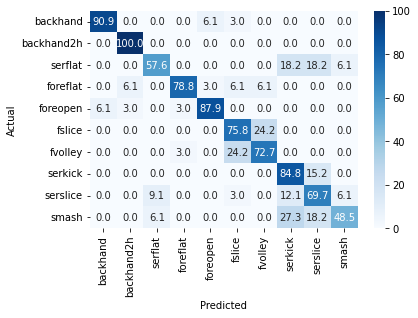

In [41]:
#best_model = TennisShotsClassificationLSTM(NUM_HIDDEN,NUM_FEATURES,NUM_CLASSES,NUM_LAYERS,BATCH_SIZE,DROPOUT, APPLY_WEIGHTS, BIDIRECTIONAL).to(device)

#best_model.load_state_dict(torch.load('/content/drive/MyDrive/Vision_Project_Utils/model.pth'))

#y_true, y_pred = test(test_dataloader, best_model)

y_true, y_pred = test(test_dataloader, model) #if you use "best_model", comment this!

#Print Precision-Recall for each class
precision = precision_score(y_true, y_pred, average=None)
precision_rounded = np.round(precision, 2)
recall = recall_score(y_true, y_pred, average=None)
recall_rounded = np.round(recall, 2)

class_names = ['backhand',
    'backhand2h',
    'serflat',
    'foreflat',
    'foreopen',
    'fslice',
    'fvolley',
    'serkick',
    'serslice',
    'smash']

table = PrettyTable()
table.field_names = ['Shot', 'Precision', 'Recall']

df = pd.DataFrame({'Precision': precision_rounded, 'Recall': recall_rounded}, index=class_names)
for label in df.index:
  table.add_row([label, df.loc[label]["Precision"], df.loc[label]["Recall"]])

print(table.get_string())

# Build the confusion matrix
cm = confusion_matrix(y_true, y_pred)
#compute percentages
cm_percentages = cm / cm.sum(axis=1)[:, np.newaxis] * 100
fmt = lambda x: '{:.1f}%'.format(x)

print("Confusion Matrix:")
sns.heatmap(cm_percentages, annot=True, fmt=".1f", cmap='Blues', annot_kws={'size':10}, xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()